In [1]:
import numpy as np
import pandas as pd

In [2]:
url = ("http://hbiostat.org/data/repo/titanic3.xls")

df = pd.read_excel(url)
orig_df = df.drop(columns=["name",
                      "ticket",
                      "home.dest",
                      "boat",
                      "body",
                      "cabin"])

In [3]:
orig_df = pd.get_dummies(orig_df, drop_first=True)

orig_df['sex_male'] = orig_df['sex_male'].astype('int64')
orig_df['embarked_Q'] = orig_df['embarked_Q'].astype('int64')
orig_df['embarked_S'] = orig_df['embarked_S'].astype('int64')

In [4]:
# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# Fix null values in X dataframe for Chapter 8
imp_mode = SimpleImputer(missing_values = np.nan, strategy="median")
cols_to_impute = ["age", "fare"]
orig_df[cols_to_impute] = imp_mode.fit_transform(orig_df[cols_to_impute])

In [5]:
orig_df.isnull().sum()

pclass        0
survived      0
age           0
sibsp         0
parch         0
fare          0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64

### Inspect and Clean Data

In [6]:
from sklearn.model_selection import train_test_split


ti_df = orig_df

y = ti_df.survived
X = ti_df.drop(["survived"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])    

In [7]:
X

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
1214,3,28.0,0,0,8.6625,1,0,1
677,3,26.0,0,0,7.8958,1,0,1
534,2,19.0,0,0,26.0000,0,0,1
1174,3,28.0,8,2,69.5500,0,0,1
864,3,28.0,0,0,7.7750,0,0,1
...,...,...,...,...,...,...,...,...
325,2,30.0,0,0,13.0000,1,0,1
919,3,18.5,0,0,7.2292,1,0,0
532,2,41.0,0,0,13.0000,1,0,1
1159,3,28.0,0,0,8.0500,0,0,1


### Chapter 18 begins here

### K-Means

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X)
km = KMeans(2, random_state=42)
km.fit(X_std)

KMeans(n_clusters=2, random_state=42)

In [9]:
X_km = km.predict(X)
X_km

C:\Users\timry\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 0])

Text(0, 0.5, 'Inertia')

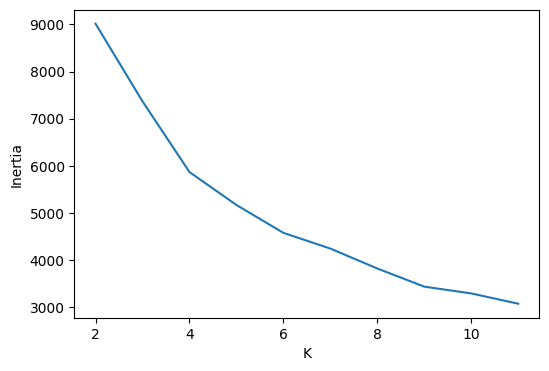

In [10]:
import matplotlib.pyplot as plt

inertias = []
sizes = range(2,12)
for k in sizes:
        k2 = KMeans(random_state=42, n_clusters=k)
        k2.fit(X_std)
        inertias.append(k2.inertia_)
fig, ax = plt.subplots(figsize=(6,4))
pd.Series(inertias, index=sizes).plot(ax=ax)
ax.set_xlabel("K")
ax.set_ylabel("Inertia")

C:\Users\timry\AppData\Local\Temp\ipykernel_14220\459292781.py:24: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  .plot(ax=ax, subplots=True, layout=(2,2))


array([[<Axes: xlabel='k'>, <Axes: xlabel='k'>],
       [<Axes: xlabel='k'>, <Axes: xlabel='k'>]], dtype=object)

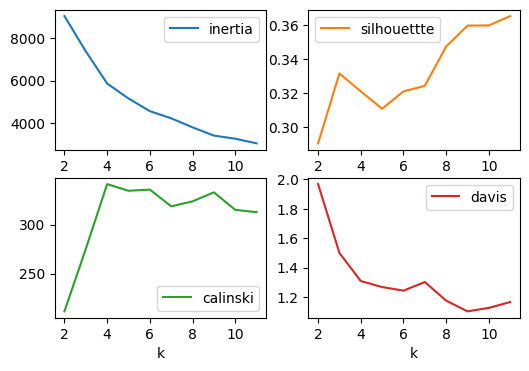

In [11]:
from sklearn import metrics
inertias = []
sils = []
chs = []
dbs = []
sizes= range(2,12)
for k in sizes:
    k2 = KMeans(random_state = 42, n_clusters=k)
    k2.fit(X_std)
    inertias.append(k2.inertia_)
    sils.append(
        metrics.silhouette_score(X_std, k2.labels_))
    chs.append(
        metrics.calinski_harabasz_score(X_std, k2.labels_))
    dbs.append(
        metrics.davies_bouldin_score(X_std, k2.labels_))
fig, ax = plt.subplots(figsize=(6,4))
(pd.DataFrame({"inertia": inertias,
               "silhouettte": sils,
               "calinski":chs,
               "davis": dbs,
               "k": sizes})
    .set_index("k")
     .plot(ax=ax, subplots=True, layout=(2,2))
)

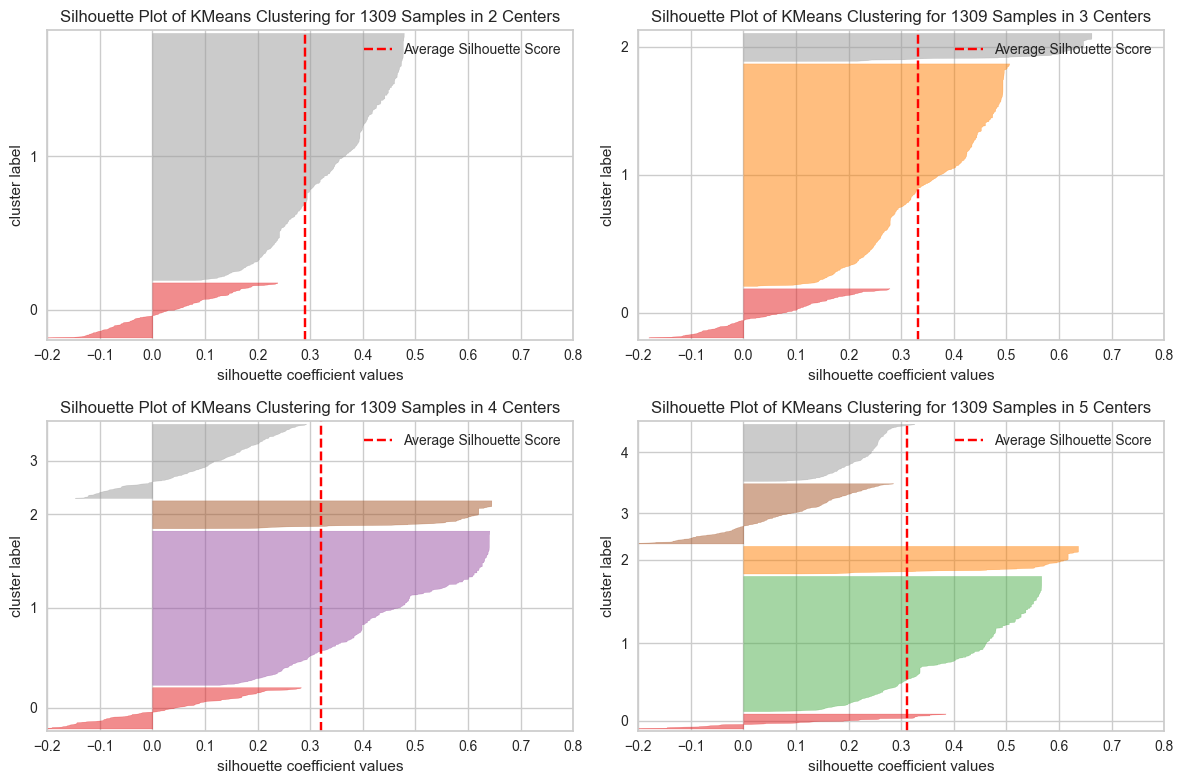

In [12]:
from yellowbrick.cluster.silhouette import SilhouetteVisualizer

fig, axes = plt.subplots(2,2, figsize=(12,8))
axes = axes.reshape(4)
for i, k in enumerate(range(2,6)):
    ax = axes[i]
    sil = SilhouetteVisualizer(
            KMeans(n_clusters=k, random_state=42),
            ax=ax)
    sil.fit(X_std)
    sil.finalize()
    ax.set_xlim(-0.2,0.8)
plt.tight_layout()



### Agglomerative (Hierarchical) Clustering

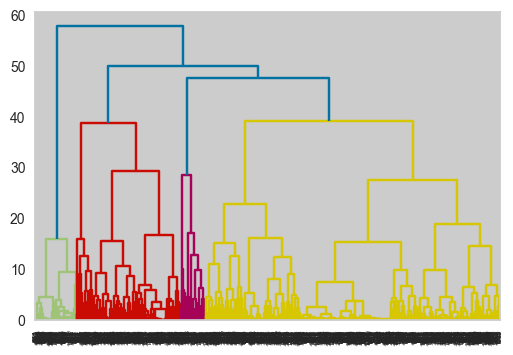

In [13]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(6,4))
dend= hierarchy.dendrogram(
    hierarchy.linkage(X_std, method="ward"))

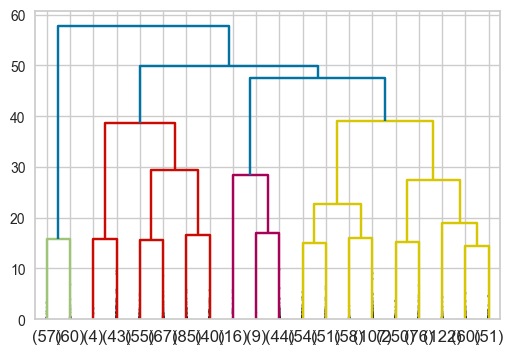

In [14]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(6,4))
dend= hierarchy.dendrogram(
    hierarchy.linkage(X_std, method="ward"),
    truncate_mode = "lastp",
    p=20,
    show_contracted=True)

In [15]:
from sklearn.cluster import AgglomerativeClustering

ag=AgglomerativeClustering(
    n_clusters=4,
    metric="euclidean",
    linkage="ward")
ag.fit(X)

AgglomerativeClustering(n_clusters=4)

### Understanding Clusters

In [16]:
km = KMeans(n_clusters=2)
km.fit(X_std)
labels = km.predict(X_std)
(
    X.assign(cluster=labels, survived=y)
    .groupby("cluster").agg(["mean","var"]).T
    )

cluster                    0            1
pclass     mean     2.347921     2.172152
           var      0.614853     0.883994
age        mean    29.065372    30.516245
           var    168.994254   159.819862
sibsp      mean     0.550328     0.379747
           var      1.349600     0.454411
parch      mean     0.426696     0.288608
           var      0.891116     0.408880
fare       mean    27.404639    46.878736
           var   1374.819638  5436.416238
sex_male   mean     0.681619     0.556962
           var      0.217252     0.247382
embarked_Q mean     0.000000     0.311392
           var      0.000000     0.214971
embarked_S mean     1.000000     0.000000
           var      0.000000     0.000000
survived   mean     0.332604     0.496203
           var      0.222222     0.250620

<Axes: >

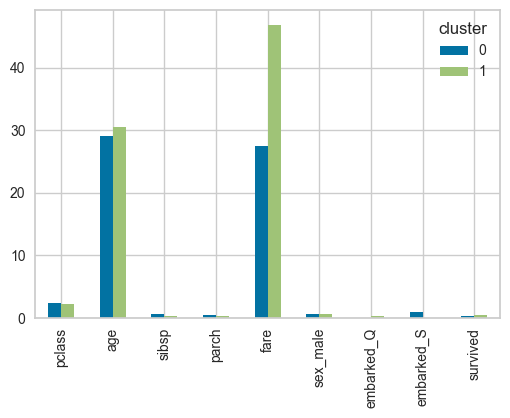

In [17]:
fig, ax = plt.subplots(figsize=(6,4))
(
    X.assign(cluster=labels, survived=y)
    .groupby("cluster").mean().T.plot.bar(ax=ax)
    )

<Axes: xlabel='PC1', ylabel='PC2'>

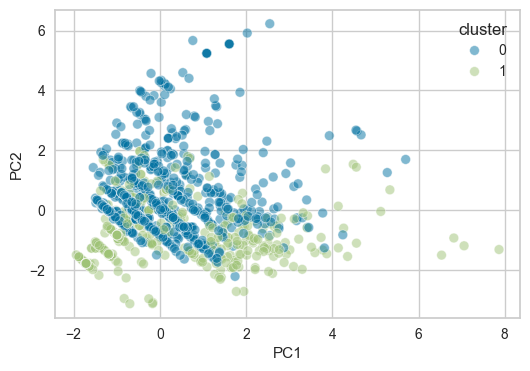

In [20]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    StandardScaler,
)

fig, ax = plt.subplots(figsize=(6, 4))
pca = PCA(random_state=42)
X_pca = pca.fit_transform(
    StandardScaler().fit_transform(X)
)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=X.assign(
        PC1=X_pca[:, 0],
        PC2=X_pca[:, 1],
        cluster=labels,
    ),
    hue="cluster",
    alpha=0.5,
    ax=ax,
)

In [29]:
(X.assign(cluster=labels).groupby("cluster").age.describe().T)

cluster,0,1
count,914.000000,395.000000
mean,29.065372,30.516245
std,12.999779,12.641988
min,0.166700,0.416700
25%,22.000000,25.000000
50%,28.000000,28.000000
75%,35.000000,35.000000
max,80.000000,71.000000


In [36]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

dt = DecisionTreeClassifier()
dt.fit(X, labels)
for col, val in sorted(
    zip(X.columns, dt.feature_importances_),
    key=lambda col_val: col_val[1],
    reverse=True):
    print(f"{col:10}{val:10.3f}")

embarked_S     1.000
pclass         0.000
age            0.000
sibsp          0.000
parch          0.000
fare           0.000
sex_male       0.000
embarked_Q     0.000


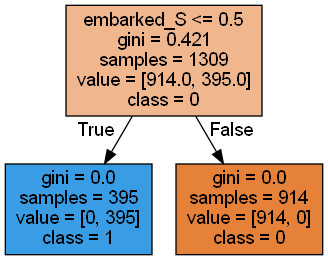

In [42]:
from io import StringIO
import pydotplus
from IPython.display import Image

dot_data = StringIO()
export_graphviz(
    dt,
    out_file=dot_data,
    feature_names=X.columns,
    class_names=["0", "1"],
    max_depth=2,
    filled=True,
)
g = pydotplus.graph_from_dot_data(
    dot_data.getvalue()
)
Image(g.create_png())